## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import io
from scipy import stats
import pickle
# from numpy.linalg import inv as inv

#Import function to get the covariate matrix that includes spike history from previous bins
from preprocessing_funcs import get_spikes_with_history

#Import decoder functions
import Decoder_funcs
from Decoder_funcs import get_vaf

/opt/anaconda/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using Theano backend.
Using gpu device 3: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5103)
/opt/anaconda/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Import Data

**Neural data should be a matrix of size "number of time bins" x "number of neurons", where each entry is the firing rate of a given neuron in a given time bin**

**The output you are decoding should be a matrix of size "number of time bins" x "number of features you are decoding"**

In [2]:
# folder='/Users/jig289/Dropbox/MATLAB/Projects/In_Progress/BMI/Processed_Data/'
folder='/home/jglaser2/Data/DecData/'

with open(folder+'s1_test_data.pickle','rb') as f:
    neural_data,vels_binned,pos_binned,acc_binned=pickle.load(f)

## Define Covariates ##

### User Options: Define what time period to use spikes from

In [3]:
#This is relevant for all decoders except the Kalman filter (KF)

bins_current=1 #Whether to use concurrent time bin of neural data
bins_before=13 #How many bins of neural data prior to the output are used for decoding
bins_after=0 #How many bins of neural data after (and including) the output are used for decoding
bins_surrounding=bins_before+bins_before+bins_after


# Below is only relevant for the KF

lag=1 #What time bin of spikes should be used relative to the output
#(lag=-1 means use the spikes 1 bin before the output)

### Get Input Covariates

In [4]:
#Function to get the covariate matrix that includes spike history from previous bins
#This puts the spikes in the format for the RNN
X=get_spikes_with_history(neural_data,bins_before,bins_after,bins_current)

#Put in "flat" format for XGB and linear decoders
X_flat=X.reshape(X.shape[0],(X.shape[1]*X.shape[2]))

#Format for Kalman filter
X_kf=neural_data

### Get Output Covariates

In [5]:
#Set decoding output for all decoders except the KF
y=vels_binned


# Set decoding output for the KF
pos=np.zeros(vels_binned.shape)
pos[0,:]=0
for i in range(pos.shape[0]-1):
    pos[i+1,0]=pos[i,0]+vels_binned[i,0]*.05
    pos[i+1,1]=pos[i,1]+vels_binned[i,1]*.05
    
temp=np.diff(vels_binned,axis=0)
acc=np.concatenate((temp,temp[-1:,:]),axis=0)

y_kf=np.concatenate((pos,vels_binned,acc),axis=1)

# y_kf=np.concatenate((pos_binned,vels_binned,acc_binned),axis=1)

### Process Covariates

In [6]:
def zscore_nan(X,axis):
    X_zscore=(X - np.nanmean(X,axis=axis)) / np.nanstd(X,axis=axis)
    return X_zscore

In [7]:
#Normalize inputs
X=zscore_nan(X,axis=0)
X_flat=zscore_nan(X_flat,axis=0)
X_kf=zscore_nan(X_kf,axis=0)

#Zero-center outputs
y_mean=np.mean(y,axis=0)
y=y-y_mean

y_kf_mean=np.mean(y_kf,axis=0)
y_kf=y_kf-y_kf_mean

In [8]:
#More Kalman filter preprocessing
num_examples=X.shape[0]

#Re-align data to take lag into account
if lag<0:
    y_kf=y_kf[-lag:,:]
    X_kf=X_kf[0:num_examples+lag,:]
if lag>0:
    y_kf=y_kf[0:num_examples-lag,:]
    X_kf=X_kf[lag:num_examples,:]

## Split into training/testing/validation sets

### User Options

In [9]:
#Set what part of data should be part of the training/testing/validation sets
training_range=[0, 0.7]
testing_range=[0.7, 0.85]
valid_range=[0.85,1]

### Split Data: For all decoders except KF

In [10]:
num_examples=X.shape[0]

#Note that each range has a buffer of"bins_before" bins at the beginning, and "bins_after" bins at the end
#This makes it so that the different sets don't include overlapping neural data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples))+bins_before,np.int(np.round(training_range[1]*num_examples))-bins_after)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples))+bins_before,np.int(np.round(testing_range[1]*num_examples))-bins_after)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples))+bins_before,np.int(np.round(valid_range[1]*num_examples))-bins_after)

#Get training data
X_train=X[training_set,:,:]
X_flat_train=X_flat[training_set,:]
y_train=y[training_set,:]

#Get testing data
X_test=X[testing_set,:,:]
X_flat_test=X_flat[testing_set,:]
y_test=y[testing_set,:]

#Get validation data
X_valid=X[valid_set,:,:]
X_flat_valid=X_flat[valid_set,:]
y_valid=y[valid_set,:]

### Split Data: For KF

In [11]:
#Number of examples after taking into account bins removed for lag alignment
num_examples_kf=X_kf.shape[0]
        
#Note that each range has a buffer of 1 bin at the beginning and end
#This makes it so that the different sets don't include overlapping data
training_set=np.arange(np.int(np.round(training_range[0]*num_examples_kf))+1,np.int(np.round(training_range[1]*num_examples_kf))-1)
testing_set=np.arange(np.int(np.round(testing_range[0]*num_examples_kf))+1,np.int(np.round(testing_range[1]*num_examples_kf))-1)
valid_set=np.arange(np.int(np.round(valid_range[0]*num_examples_kf))+1,np.int(np.round(valid_range[1]*num_examples_kf))-1)

#Get training data
X_kf_train=X_kf[training_set,:]
y_kf_train=y_kf[training_set,:]

#Get testing data
X_kf_test=X_kf[testing_set,:]
y_kf_test=y_kf[testing_set,:]

#Get validation data
X_kf_valid=X_kf[valid_set,:]
y_kf_valid=y_kf[valid_set,:]

## Run Decoders

### Wiener Filter (Linear Regression)

In [15]:
#Fit model
model_regr=Decoder_funcs.lin_reg_model(X_flat_train,y_train)
#Get predictions
y_valid_pred_lin=model_regr.predict(X_flat_valid)
#Get metric of fit
vafs_lin=get_vaf(y_valid,y_valid_pred_lin)
print('VAFS:', vafs_lin)

('VAFS:', [0.70518636964084935, 0.67680790561615423])


### Wiener Cascade (Linear Nonlinear Model)

In [19]:
#Fit model
models_wc=Decoder_funcs.wiener_casc_model(X_flat_train,y_train,deg=3)
#Get predictions
y_valid_pred_wc=Decoder_funcs.wiener_casc_predict(models_wc,X_flat_valid)
#Get metric of fit
vafs_wc=get_vaf(y_valid,y_valid_pred_wc)
print('VAFS:', vafs_wc)

('VAFS:', [0.71235263777357383, 0.69691885346071958])


### XGBoost (Extreme Gradient Boosting)

In [29]:
#Fit model
model_xgb=Decoder_funcs.xgb_model(X_flat_train,y_train,max_depth=4,num_round=300)
#Get predictions
y_valid_pred_xgb=Decoder_funcs.xgb_predict(model_xgb,X_flat_valid)
#Get metric of fit
vafs_xgb=get_vaf(y_valid,y_valid_pred_xgb)
print('VAFS:', vafs_xgb)

('VAFS:', [0.7408971919698405, 0.73487829845927599])


In [ ]:
3/200: 0.72974177174204813, 0.73024356609825891
4/200: 0.73968582352971746, 0.73150808401927347 *** (a drop less than w/ 300, but will be faster)
5/200: 0.73316104927055448, 0.72978160849225038
    
3/300: 0.7377630522138201, 0.73359832453786589
4/300: 0.7408971919698405, 0.73487829845927599

### Dense NN

In [12]:
#Fit model
model_dnn=Decoder_funcs.DNN_model(X_flat_train,y_train,num_layers=1,units=400,dropout=.5,num_epochs=5)
#Get predictions
y_valid_pred_dnn=model_dnn.predict(X_flat_valid)
#Get metric of fit
vafs_dnn=get_vaf(y_valid,y_valid_pred_dnn)
print('VAFS:', vafs_dnn)

('VAFS:', [0.71228042265933977, 0.69619957218561623])


In [ ]:
400/0/10: 0.64646747052353537, 0.64888248883409094
400/.25/10: 0.69170876983974872, 0.68972463657455829
400/.5/10: 0.71160295141044827, 0.68919537501710693
400/.75/10: 0.71533407708526231, 0.68223399031392939
    
400/0/5: 0.67865596514742754, 0.67021758469965675
400/.25/5: 0.69683673018632719, 0.69873000355393711
400/.5/5: 0.71243764814871968, 0.69290944647111519

400/.5/15: 0.70672181135375389, 0.69465989681454365
400/.75/20: 0.70859306673280109, 0.68335289459155968    
    
200/.25/5: 0.70242236527693014, 0.68862354253370861
200/.5/5: 0.70475909440777862, 0.68655330137650772
200/.5/10: 0.71116467418521656, 0.69010621402724803
    
200/.5/15: 0.70785961546724985, 0.69134672244420303
    
    
5/0/10: 0.70713354707205611, 0.68983236259636138

In [16]:
#Fit model
model_dnn2=Decoder_funcs.DNN_model(X_flat_train,y_train,num_layers=2,units=200,dropout=.5,num_epochs=20)
#Get predictions
y_valid_pred_dnn2=model_dnn2.predict(X_flat_valid)
#Get metric of fit
vafs_dnn2=get_vaf(y_valid,y_valid_pred_dnn2)
print('VAFS:', vafs_dnn2)

('VAFS:', [0.71755420579551243, 0.7176150263551283])


In [ ]:
200/.5/10: 0.72128328752257642, 0.69327333484241604
200/.5/15: 0.72982701033980324, 0.71154276896262003
200/.5/20: 0.73693832927396097, 0.71641267224053462 ***
200/.5/30: 0.72788136885209276, 0.72228028847387049    
    
400/.25/10: 0.71851133728612515, 0.71317166564602785
400/.25/20: 0.71456935927224263, 0.71872539939760216
    
400/.5/10: 0.69980285300944245, 0.69270571683263327
400/.5/20: 0.71706994396848289, 0.70988989524976842
    
    
    
200/.5/20/2: 0.71654366937788661, 0.71078873599641712

In [ ]:
1/2 as many units in 2nd layer

400/.5/10: 0.70747553529571461, 0.694613319905659
200/.5/10: 0.72212613514224144, 0.69773205560359108
100/.5/10: 0.70863453954514544, 0.68160729857927493
    
200/.5/15: 0.72107896908444968, 0.70932992260995842 ***

### Simple RNN

In [30]:
#Fit model
model_rnn=Decoder_funcs.SimpleRNN_model(X_train,y_train,units=400,dropout=0,num_epochs=5)
#Get predictions
y_valid_pred_rnn=model_rnn.predict(X_valid)
#Get metric of fit
vafs_rnn=get_vaf(y_valid,y_valid_pred_rnn)
print('VAFS:', vafs_rnn)

('VAFS:', [0.71685987200456491, 0.73296101004923675])


In [ ]:
400/do=0/10: 0.74307395545975607, 0.7657178519266612
400/do=.25/10: 0.75450395413147608, 0.74860947652046206

200/do=0/10: 0.72866965957346763, 0.73276927563036365
400/do=0/5: 0.76298928872260241, 0.78238976571087926 ***
    
400/0/3: 0.71685987200456491, 0.73296101004923675
600/0/5: low

### GRU (Gated Recurrent Unit)

In [38]:
#Fit model
model_gru=Decoder_funcs.GRU_model(X_train,y_train,units=400,dropout=.25,num_epochs=5)
#Get predictions
y_valid_pred_gru=model_gru.predict(X_valid)
#Get metric of fit
vafs_gru=get_vaf(y_valid,y_valid_pred_gru)
print('VAFS:', vafs_gru)

('VAFS:', [0.78339954124903244, 0.80471974341608588])


In [ ]:
400/0/5: 0.79103911716194519, 0.78608721045149577
400/0/10: 0.78525010361298997, 0.79205307579390183
400/.25/5: 0.78339954124903244, 0.80471974341608588
400/.25/10: 0.79653295584467121, 0.80876037362646813


### LSTM (Long Short Term Memory)

In [40]:
#Fit model
model_lstm=Decoder_funcs.LSTM_model(X_train,y_train,units=400,dropout=.25,num_epochs=5)
#Get predictions
y_valid_pred_lstm=model_lstm.predict(X_valid)
#Get metric of fit
vafs_lstm=get_vaf(y_valid,y_valid_pred_lstm)
print('VAFS:', vafs_lstm)

('VAFS:', [0.80120765256627213, 0.80913846953427804])


In [ ]:
400/0/5: 0.79020577823923899, 0.79900540348964255
400/0/10: 0.7904522331731878, 0.79623596717122691
400/.25/5: 0.80120765256627213, 0.80913846953427804
400/.25/10: 0.81032474400367871, 0.81501664464148438

### Kalman Filter

In [119]:
#Fit model
model_kf=Decoder_funcs.kf_model(X_kf_train,y_kf_train)
#Get predictions
y_valid_pred_kf=Decoder_funcs.kf_predict(model_kf,X_kf_valid,y_kf_valid)
#Get metric of fit
vafs_kf=get_vaf(y_kf_valid,y_valid_pred_kf)
print('VAFS:',vafs_kf[2:4])

('VAFS:', [0.71174282981917925, 0.6914042873490962])


In [ ]:
derived
0: [0.69198167244345621, 0.67276350982595945]
1: [0.71174282981917925, 0.6914042873490962]
    
orig
-2: [0.543448952339327, 0.40749208788561919]
-1: [0.6380358559916337, 0.57132157616571078]
0: [0.68846750389291855, 0.66689049715183302]
1: [0.70159458615440462, 0.67544598578846338]
2: [0.6856831125279228, 0.62874672600763426]

In [54]:
vafs_kf

[0.5661442774055665,
 0.73229360062314219,
 0.68846750389291855,
 0.66689049715183302,
 0.41694206122880972,
 0.25941869619406388]

## Make Plots

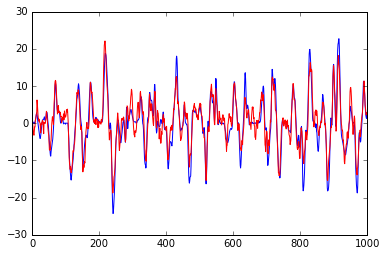

In [17]:
#As an example, I plot an example 1000 values of the x velocity (column index 0), both true and predicted with the Wiener filter
#Note that I add back in the mean value, so that both true and predicted values are in the original coordinates
fig_x_lin=plt.figure()
plt.plot(y_valid[1000:2000,0]+y_mean[0],'b')
plt.plot(y_valid_pred_lin[1000:2000,0]+y_mean[0],'r')
#Save figure
# fig_x_lin.savefig('x_velocity_decoding.eps')